In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Feature Information

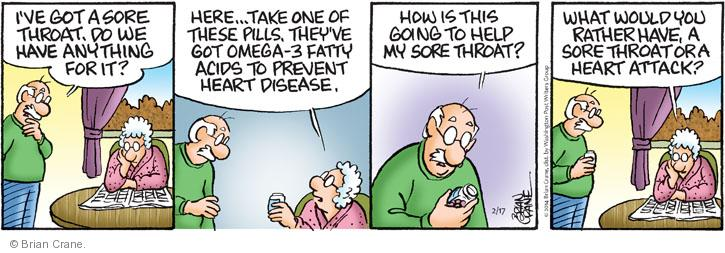

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: A blood disorder called thalassemia


# Import Libraries

In [ ]:
#-------Pandas Settings------------
from warnings import filterwarnings
filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

# Install some libraries
!pip install researchpy # for some statistical operations
!pip install dython # for categorical and numeric correlations

# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy
import scipy # for statistics
from scipy import stats
import yellowbrick #for some special visualizations
from yellowbrick.target import class_balance
from dython import nominal
from yellowbrick.features import rank1d,rank2d #for shapiro wilks visualization
from sklearn.metrics import pairwise_distances, matthews_corrcoef,f1_score,accuracy_score
from sklearn.neighbors import LocalOutlierFactor # for outlier detection
from sklearn.ensemble import RandomForestClassifier,VotingClassifier ,IsolationForest,BaggingClassifier,StackingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier,plot_tree
from xgboost import plot_tree
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from mlxtend.plotting import plot_learning_curves,plot_decision_regions

from yellowbrick.classifier import ClassificationReport, confusion_matrix,precision_recall_curve,classification_report,roc_auc
from yellowbrick.classifier import PrecisionRecallCurve,ConfusionMatrix,ROCAUC
from yellowbrick.model_selection import FeatureImportances,feature_importances
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots # for partial dependence plots
import shap #for shap values
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import validation_curve

# Import Data

In [ ]:
data=pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")
df=data.copy() # I'm copying it just in case.
df.head()

In [ ]:
df.memory_usage(index=False)

# Exploratory Data Analysis

In [ ]:
df.info()

In [ ]:
df[["age","trestbps","chol","thalach","oldpeak"]].describe().T

In [ ]:
def show_statistics(df):
    frame=pd.DataFrame(columns=scipy.stats.describe(df)._asdict().keys())
    columns=df.select_dtypes(exclude=["object"]).columns
    for i in columns:
        d=scipy.stats.describe(df[i])._asdict()
        frame=frame.append(d,ignore_index=True)
    frame.index=columns
    return frame

show_statistics(df[["age","trestbps","chol","thalach","oldpeak"]])

In [ ]:
researchpy.summary_cat(df[["target","sex"]])

In [ ]:
df.isnull().sum().to_frame(name="missing")

Apparently, there is no missing values.

In [ ]:
df.head()

I'm changing the types of some columns because I'll make visualizations and create some models based on tree so it's better to do this for now.

In [ ]:
columns_to_convert=["sex","cp","fbs","restecg","exang","slope","ca","thal"]
for i in columns_to_convert:
    df[i]=df[i].astype("object")

In [ ]:
df.dtypes.to_frame(name="types").T

In [ ]:
sns.heatmap(df[["age","trestbps","chol","thalach","oldpeak"]].corr(),annot=True,cmap="coolwarm");

In [ ]:
crosstab, res = researchpy.crosstab(df.sex, df.target, test= "chi-square")
crosstab

In [ ]:
res 

According to the test, there is a meaningful difference between men and women in terms of being a patient or not.

In [ ]:
plt.figure(figsize=(12,5));
plt.subplot(121)
#class_balance(df.target);
df.target.value_counts().plot.bar()

plt.subplot(122)
plt.pie(df.target.value_counts(),labels=["Patient","Healthy"],autopct='%1.1f%%',radius=1);
plt.title("Target rates", bbox={'facecolor':'0.9', 'pad':5},loc="center");

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot(df.sex);

plt.subplot(132)
plt.pie(df[df.sex==1].groupby("target")["sex"].value_counts(),autopct='%1.1f%%',radius=1,labels=["Healthy Male","Male Patient"]);

plt.subplot(133)
plt.pie(df[df.sex==0].groupby("target")["sex"].value_counts(),autopct='%1.1f%%',radius=1,labels=["Healthy Female","Female Patient"]);

# 1-male
# 0-female

In [ ]:
f, axs = plt.subplots(4,2,figsize=(15,10))

f.tight_layout()

sns.countplot(df.target,hue="sex",data=df,ax=axs[0][0]);

sns.countplot(df.target,hue="cp",data=df,ax=axs[1][0]);

sns.countplot(df.target,hue="fbs",data=df,ax=axs[2][0]);

sns.countplot(df.target,hue="restecg",data=df,ax=axs[3][0]);

sns.countplot(df.target,hue="exang",data=df,ax=axs[0][1]);

sns.countplot(df.target,hue="slope",data=df,ax=axs[1][1]);

sns.countplot(df.target,hue="ca",data=df,ax=axs[2][1]);

sns.countplot(df.target,hue="thal",data=df,ax=axs[3][1]);

In [ ]:
plt.figure(figsize=(17,5));
plt.subplot(131)
sns.heatmap(pd.crosstab(df.sex,df.target),annot=True,fmt='g',cmap="coolwarm"); 
plt.subplot(132)
sns.heatmap(pd.crosstab(df.cp,df.target),annot=True,fmt='g',cmap="YlGnBu"); 
plt.subplot(133)
sns.heatmap(pd.crosstab(df.ca,df.target),annot=True,fmt='g',cmap="YlOrRd"); 
# I'm adding fmt parameter, otherwise it would contain e number.

In [ ]:
pd.crosstab(df.age,df.target).plot.bar(figsize=(15,5));

In [ ]:
for i in ["age","trestbps","chol","thalach","oldpeak"]:
    sns.catplot(x="sex",y=i,hue="target",data=df,kind="box",aspect=2); #1 male 0 female

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.distplot,"age",color="orange");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.distplot,"chol",color="orangered");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.distplot,"oldpeak",color="black");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.distplot,"thalach",color="purple");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.regplot,"oldpeak","age",color="b");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.regplot,"chol","age",color="purple");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.regplot,"trestbps","age",color="green");

In [ ]:
sns.FacetGrid(df, col="target",row="sex",height=3, aspect=2).map(sns.regplot,"thalach","age",color="r");


In [ ]:
g = sns.JointGrid(x="age", y="chol", data=df, space=0)
g = g.plot_joint(sns.kdeplot, cmap="Purples_d")
g = g.plot_marginals(sns.kdeplot, shade=True,color="m")

In [ ]:
g = sns.JointGrid(x="age", y="thalach", data=df, space=0)
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, shade=True,color="green")

In [ ]:
g = sns.JointGrid(x="oldpeak", y="thalach", data=df, space=0)
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, shade=True,color="b")

In [ ]:
sns.scatterplot(x="age",y="thalach",hue="target",data=df,style="target",palette="bright");
plt.title("Maximum Hearth rate vs. Age");

In [ ]:
sns.scatterplot(x="age",y="thalach",hue="sex",data=df,style="target",palette="bright");

In [ ]:
sns.lmplot(x="thalach", y="age", hue="target", data=df,aspect=2);

In [ ]:
df.hist(figsize=(12,10),color="r");

In [ ]:

_, axes = plt.subplots(ncols=2, figsize=(12,5));

rank1d(df[["age","trestbps","chol","thalach","oldpeak"]], ax=axes[0], show=False);
rank2d(df[["age","trestbps","chol","thalach","oldpeak"]], ax=axes[1], show=False);
plt.show()

# Train Test Split

In [ ]:
X=df.drop("target",axis=1)
y=df["target"]

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

# Outlier Detection

## IQR 

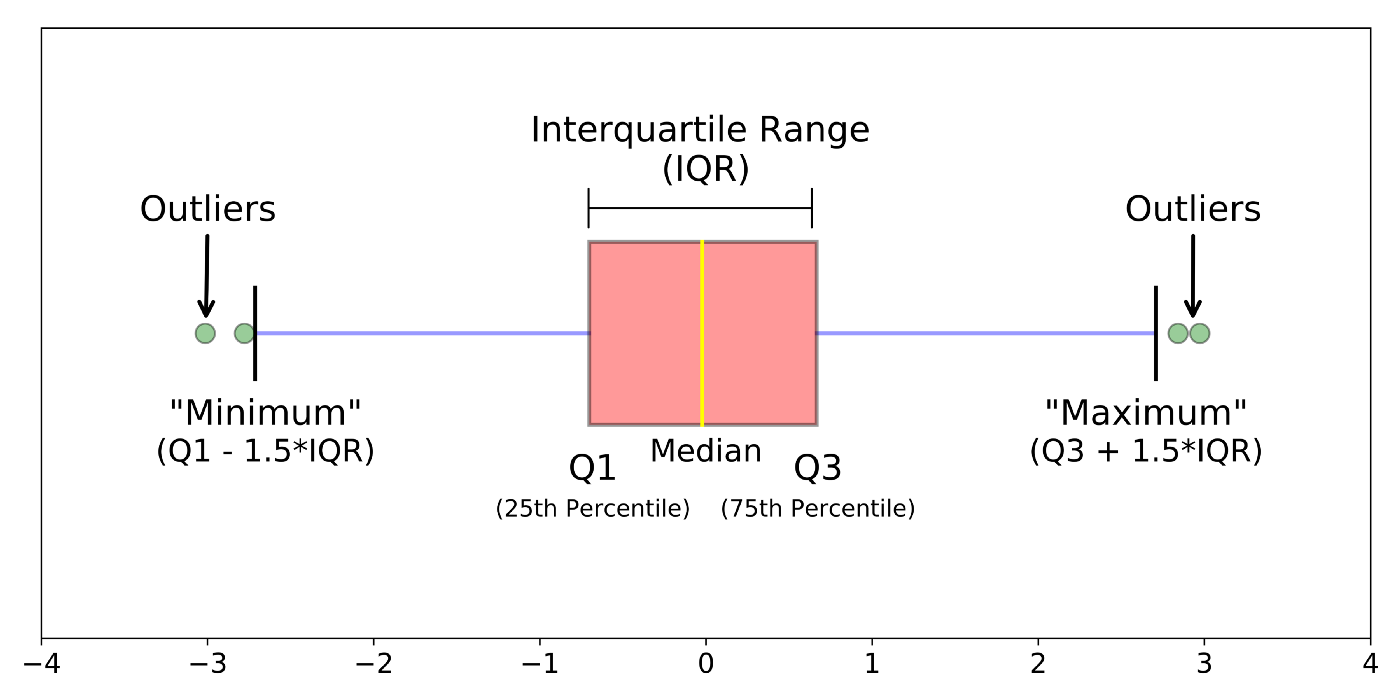

In [ ]:
plt.figure(figsize=(15,7));
plt.subplot(151)
sns.boxplot(X_train["age"],orient="vertical");
plt.subplot(152)
sns.boxplot(X_train["trestbps"],orient="vertical");
plt.subplot(153)
sns.boxplot(X_train["chol"],orient="vertical");
plt.subplot(154)
sns.boxplot(X_train["thalach"],orient="vertical");
plt.subplot(155)
sns.boxplot(X_train["oldpeak"],orient="vertical");

In [ ]:
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    #stats.iqr(df[variable])
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

upper,lower=find_skewed_boundaries(X_train,"age",1.5)
print("Upper:",upper,"Lower:",lower)
X_train[(X_train["age"]>upper) | (X_train["age"]<lower)]
  

In [ ]:
upper,lower=find_skewed_boundaries(df,"trestbps",1.5)
print("Upper:",upper,"Lower:",lower)
outlier_indexes_iqr=[]
for index in X_train[(X_train["trestbps"]>upper) | (X_train["trestbps"]<lower)].index:
    outlier_indexes_iqr.append(index)
print("Outlier indexes:",outlier_indexes_iqr)
X_train.loc[outlier_indexes_iqr]


In [ ]:
upper,lower=find_skewed_boundaries(df,"thalach",1.5)
print("Upper:",upper,"Lower:",lower)
for index in X_train[(X_train["thalach"]>upper) | (X_train["thalach"]<lower)].index:
    outlier_indexes_iqr.append(index)
outlier_indexes_iqr

In [ ]:
upper,lower=find_skewed_boundaries(df,"oldpeak",1.5)
print("Upper:",upper,"Lower:",lower)
for index in X_train[(X_train["oldpeak"]>upper) | (X_train["oldpeak"]<lower)].index:
    outlier_indexes_iqr.append(index)
outlier_indexes_iqr

In [ ]:
outlier_indexes_iqr=set(outlier_indexes_iqr)
X_train.loc[outlier_indexes_iqr]

## Local Outlier Factor

Local outlier factor is one of the methods used to detect outlier observations.Outlier detection methods can be distribution-based,depth-based,clustering-based and density-based. LOF allows to define outliers by doing density-based scoring. It is similar to the KNN (nearest neighbor search) algorithm. The difference is that we’re trying to find observations that are close together in KNN, but we’re trying to find observations that are not alike in LOF.

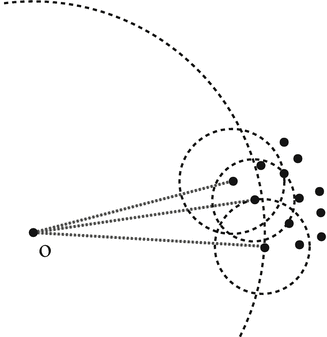

You can read my article and check the numerical example to understand LOF. https://www.datasciencearth.com/en/local-outlier-factor-2/

In [ ]:
clf=LocalOutlierFactor(n_neighbors=7)
clf

In [ ]:
pred=clf.fit_predict(X_train)
pred[:40]

In [ ]:
X_train[pred==-1]

In [ ]:
outlier_indexes_lof = X_train[pred==-1].index
print(outlier_indexes_lof)

In [ ]:
plt.figure(figsize=(20,5));
plt.subplot(141)
sns.scatterplot(X_train["age"],X_train["chol"]);
plt.subplot(142)
sns.scatterplot(X_train["age"],X_train["thalach"]);
plt.subplot(143)
sns.scatterplot(X_train["age"],X_train["trestbps"]);
plt.subplot(144)
sns.scatterplot(X_train["age"],X_train["oldpeak"]);

## Isolation Forests

Isolation Forest, unlike other density-based or distance-based methods, tries to separate outliers from normal points by creating random trees. Selects a random feature on each node and sets a random treshold to split it in half.

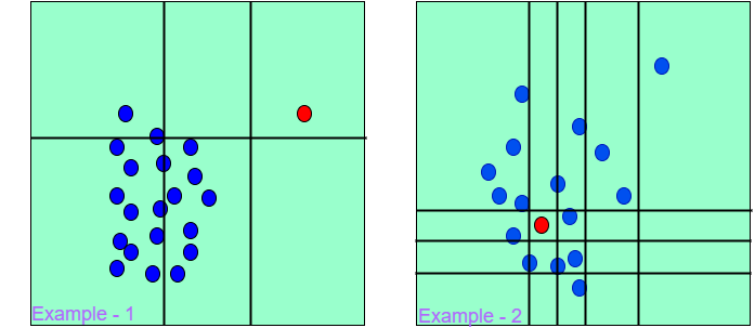

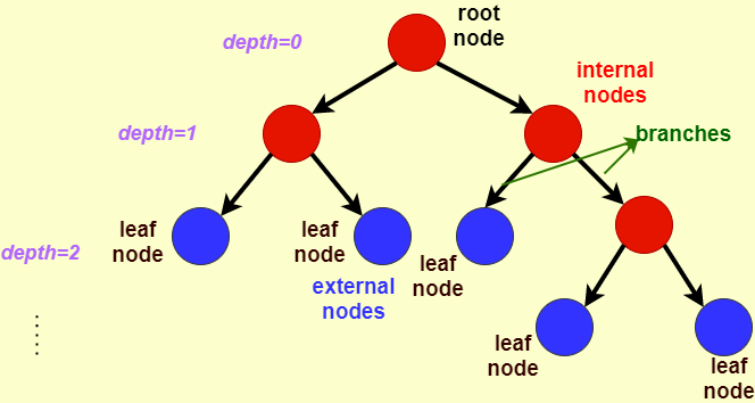

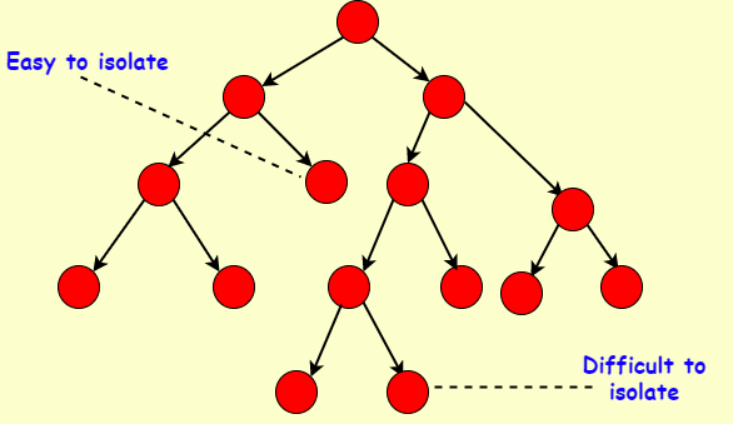

In [ ]:
clf_=IsolationForest(random_state=123,n_estimators=100,bootstrap=False,contamination=0.05).fit(X_train)
pred=clf_.predict(X_train)
outlier_indexes_iso=X_train[pred==-1].index
outlier_indexes_iso

In [ ]:
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)

In [ ]:
X_train.drop(columns=["sex_1","fbs_1","exang_1"],axis=1,inplace=True)
X_test.drop(columns=["sex_1","fbs_1","exang_1"],axis=1,inplace=True)

In [ ]:
X_train=X_train.drop(outlier_indexes_iqr)
y_train=y_train.drop(outlier_indexes_iqr)


In [ ]:
X_train.shape,y_train.shape

In [ ]:
plt.figure(figsize=(15,7));
plt.subplot(151)
sns.boxplot(X_train["age"],orient="vertical");
plt.subplot(152)
sns.boxplot(X_train["trestbps"],orient="vertical");
plt.subplot(153)
sns.boxplot(X_train["chol"],orient="vertical");
plt.subplot(154)
sns.boxplot(X_train["thalach"],orient="vertical");
plt.subplot(155)
sns.boxplot(X_train["oldpeak"],orient="vertical");

In [ ]:
X_train[X_train.oldpeak>=4].index


In [ ]:
X_train[X_train.chol>390].index

In [ ]:
X_train=X_train.drop([220,295,28,85,246,96])
y_train=y_train.drop([220,295,28,85,246,96])


In [ ]:
plt.figure(figsize=(15,7));
plt.subplot(151)
sns.boxplot(X_train["age"],orient="vertical");
plt.subplot(152)
sns.boxplot(X_train["trestbps"],orient="vertical");
plt.subplot(153)
sns.boxplot(X_train["chol"],orient="vertical");
plt.subplot(154)
sns.boxplot(X_train["thalach"],orient="vertical");
plt.subplot(155)
sns.boxplot(X_train["oldpeak"],orient="vertical");

In [ ]:
X_train.shape,y_train.shape

In [ ]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## Logistic Regression

In [ ]:
clf=LogisticRegression(random_state=0,C=0.7,solver="liblinear")
clf_model=clf.fit(X_train_scaled,y_train)
pred=clf.predict(X_test_scaled)
accuracy_score(y_test,pred)


In [ ]:
clf.score(X_train_scaled,y_train)

In [ ]:
clf.classes_

In [ ]:
clf.predict_proba(X_test_scaled)[:3]

In [ ]:
clf.get_params()

In [ ]:
pred_cv=LogisticRegressionCV(cv=10,random_state=0).fit(X_train_scaled,y_train).predict(X_test_scaled)
accuracy_score(y_test,pred_cv)

In [ ]:
plot_learning_curves(X_train_scaled,y_train,X_test_scaled,y_test,clf);

In [ ]:
avg_expected_loss, avg_bias, avg_var=bias_variance_decomp(clf,X_train_scaled,
                                                          y_train.values,X_test_scaled,
                                                          y_test.values,random_seed=0)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

If the bias is larger than zero, we also say that the estimator is positively biased, if the bias is smaller than zero, the estimator is negatively biased, and if the bias is exactly zero, the estimator is unbiased. 

In [ ]:

def visualize_result(model,X_train,X_test,y_train,y_test):
    fig, axes = plt.subplots(2, 2,figsize=(15,12))
    model = model
    visualgrid = [
        PrecisionRecallCurve(model,ax=axes[0][0]),
        ConfusionMatrix(model, ax=axes[0][1]),
        ClassificationReport(model, ax=axes[1][0]),
        ROCAUC(model, ax=axes[1][1]),
    ]

    for viz in visualgrid:
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.finalize()

    plt.show()


In [ ]:
visualize_result(clf,X_train_scaled,X_test_scaled,y_train,y_test)

In [ ]:
matthews_corrcoef(y_test,pred)

## Feature Importance

### Permutation Importance

In [ ]:
perm = PermutationImportance(clf_model, random_state=1).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

### Feature Importance

In [ ]:
feature_importances(clf_model,pd.DataFrame(X_train_scaled,columns=X_train.columns),y_train);

In [ ]:
clf.coef_

In [ ]:

importance = clf_model.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance);
plt.show()

 ## Partial Dependence Plot

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001).A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship.

For more : https://christophm.github.io/interpretable-ml-book/pdp.html

In [ ]:
x_test_frame=pd.DataFrame(X_test_scaled,columns=X_test.columns)
pdp_oldpeak = pdp.pdp_isolate(model=clf_model, dataset=x_test_frame,
                            model_features=x_test_frame.columns, feature='oldpeak')

pdp.pdp_plot(pdp_oldpeak, 'oldpeak')
plt.show()

In [ ]:
pdp_oldpeak = pdp.pdp_isolate(model=clf_model, dataset=x_test_frame,
                            model_features=x_test_frame.columns, feature='thalach')

pdp.pdp_plot(pdp_oldpeak, 'thalach')
plt.show()

In [ ]:
pdp_age = pdp.pdp_isolate(model=clf_model, dataset=x_test_frame,
                            model_features=x_test_frame.columns, feature='age')

pdp.pdp_plot(pdp_age, 'age')
plt.show()

In [ ]:
pdp_ca0 = pdp.pdp_isolate(model=clf_model, dataset=x_test_frame,
                            model_features=x_test_frame.columns, feature='ca_0')

pdp.pdp_plot(pdp_ca0, 'ca_0')
plt.show()

## Shap Values

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition.

For more : https://christophm.github.io/interpretable-ml-book/shap.html

In [ ]:
shap.initjs() # load JS visualization code to notebook

In [ ]:
# summarize the effects of all the features
explainer=shap.LinearExplainer(clf_model,X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

In [ ]:
shap.summary_plot(shap_values, pd.DataFrame(X_train_scaled,columns=X_train.columns), plot_type="bar")

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_scaled)

**WORK IN PROGRESS...**